In [1]:
from DataLoader import FaceLandmarkDataset
from se3.model import SE3Unet
import yaml
import torch
from torch import nn
from torch.utils.data import Dataset
from tqdm import trange
import matplotlib.pyplot as plt

/Users/mattia/miniconda3/envs/cv-dgl/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open('./test-conf-example.yaml') as fp:
    conf = yaml.safe_load(fp)

    
test_set = FaceLandmarkDataset(**conf['test_set'])
model = SE3Unet(**conf['model'])

checkpoint = torch.load(conf['checkpoint_fpath'], map_location='cpu')

model.load_state_dict(checkpoint['model_state_dict'])

device = conf['hyper']['device']
batch_size = conf['hyper']['batch_size']
features = conf['hyper']['features']

model.to(device)
#model.eval()

Loading dataset...
Path file:  ./Facescape/Test/test_neutral.npy
Preprocessing: spatial_transformer
Dataset: Facescape
Category: Neutral


Len dataset:  torch.Size([167, 8192, 3])
Face:  torch.Size([167, 8192, 3])
Landmark:  torch.Size([167, 68, 3])
Heatmaps:  torch.Size([167, 8192, 68])
Scale:  torch.Size([167])


SE3Unet(
  (down_branch): ModuleList(
    (0): SE3ConvBlock(
      (Gblock): ModuleList(
        (0): GSE3Res(
          (GMAB): ModuleDict(
            (v): GConvSE3Partial(structure=[(5, 0), (5, 1), (5, 2)])
            (k): GConvSE3Partial(structure=[(5, 1)])
            (q): G1x1SE3(structure=[(5, 1)])
            (attn): GMABSE3(n_heads=1, structure=[(5, 0), (5, 1), (5, 2)])
          )
          (cat): GCat(structure=[(5, 0), (6, 1), (5, 2)])
          (project): G1x1SE3(structure=[(5, 0), (5, 1), (5, 2)])
        )
        (1): GNormTFN()
        (2): GSE3Res(
          (GMAB): ModuleDict(
            (v): GConvSE3Partial(structure=[(5, 0), (5, 1), (5, 2)])
            (k): GConvSE3Partial(structure=[(5, 0), (5, 1), (5, 2)])
            (q): G1x1SE3(structure=[(5, 0), (5, 1), (5, 2)])
            (attn): GMABSE3(n_heads=1, structure=[(5, 0), (5, 1), (5, 2)])
          )
          (cat): GCat(structure=[(10, 0), (10, 1), (10, 2)])
          (project): G1x1SE3(structure=[(5, 0), (

In [7]:
with torch.no_grad():
    pointclouds, y = test_set[5:7]
    y_hat = model(
        pointclouds.to(device),
        features,
        2
    )

In [3]:
def compute_scores(y, y_hat):

    thresholds = torch.arange(0, 1, 0.01)
    #arg_threshold = torch.where(thresholds == 0.5)[0].item()

    precisions = torch.zeros(y.shape[0], thresholds.shape[0])
    recalls = torch.zeros(y.shape[0], thresholds.shape[0])
    f1_scores = torch.zeros(y.shape[0], thresholds.shape[0])


    for i, threshold in enumerate(thresholds):
        y_bin_hat = (torch.sigmoid(y_hat) > threshold).float()

        tp = ((y == 1) & (y_bin_hat == 1)).sum(axis=-2).sum(-1)
        fn = ((y == 1) & (y_bin_hat == 0)).sum(axis=-2).sum(-1)
        fp = ((y == 0) & (y_bin_hat == 1)).sum(axis=-2).sum(-1)
        tn = ((y == 0) & (y_bin_hat == 0)).sum(axis=-2).sum(-1)

        # tp = ((y == 1) & (y_bin_hat == 1)).sum(axis=-2)
        # fn = ((y == 1) & (y_bin_hat == 0)).sum(axis=-2)
        # fp = ((y == 0) & (y_bin_hat == 1)).sum(axis=-2)
        # tn = ((y == 0) & (y_bin_hat == 0)).sum(axis=-2)

        precision = tp / (tp + fp)
        recall = tp / (tp + fn )
        f1_score = 2 * tp / (2 * tp + fp + fn)

        precisions[:, i] = precision
        recalls[:, i] = recall
        f1_scores[:, i] = f1_score


        # precisions[:, i] = precision.mean(axis=-1)
        # recalls[:, i] = recall.mean(axis=-1)
        # f1_scores[:, i] = f1_score.mean(axis=-1)

    precisions = torch.nan_to_num(precisions)
    recalls = torch.nan_to_num(recalls)
    f1_scores = torch.nan_to_num(f1_scores)

    return thresholds, precisions, recalls, f1_scores

In [7]:
def plot_metrics(thresholds, precision, recall, f1_scores, save=True):

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 7))
    plt.style.use('seaborn-v0_8-darkgrid')

    def style_subplot(ax, title):
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_title(title, fontsize=12, fontweight='bold', pad=15)
        ax.tick_params(labelsize=10)

    # 1. Precision Curve
    ax1.plot(thresholds, precision, color='#2E86C1', lw=2)
    ax1.set_xlabel('Threshold', fontsize=10, fontweight='bold')
    ax1.set_ylabel('Precision', fontsize=10, fontweight='bold')
    style_subplot(ax1, 'Precision Curve')

    # 2. Recall Curve
    ax2.plot(thresholds, recall, color='#27AE60', lw=2)
    ax2.set_xlabel('Threshold', fontsize=10, fontweight='bold')
    ax2.set_ylabel('Recall', fontsize=10, fontweight='bold')
    style_subplot(ax2, 'Recall Curve')

    # 3. F1 Score Curve
    ax3.plot(thresholds, f1_scores, color='#8E44AD', lw=2)
    ax3.set_xlabel('Threshold', fontsize=10, fontweight='bold')
    ax3.set_ylabel('F1 Score', fontsize=10, fontweight='bold')
    style_subplot(ax3, 'F1 Score Curve')

    # 4. Precision-Recall Curve
    ax4.plot(recall, precision, color='#E67E22', lw=2)

    ax4.set_xlabel('Recall', fontsize=10, fontweight='bold')
    ax4.set_ylabel('Precision', fontsize=10, fontweight='bold')
    style_subplot(ax4, 'Precision-Recall Curve')

    fig.suptitle('Classification Metrics Analysis', fontsize=14, fontweight='bold')

    plt.tight_layout()

    if save:
        plt.savefig('classification_metrics.png', dpi=300, bbox_inches='tight')

    plt.show()

In [4]:

#print(y_hat.shape)
#compute_scores(y > 0.5, y_hat)

def test_loop(model: nn.Module, test_set: Dataset, batch_size:int, features: str, device: str):
    model.eval()

    precisions = []
    recalls = []
    f1_scores = []

    with torch.no_grad():
        for i in trange(0, len(test_set), batch_size, desc="Testing.."):
            pointclouds, y = test_set[i : i + batch_size]
            
            y_hat = model(
                pointclouds.to(device),
                features,
                y.shape[0]
            )

            thresholds, precision_per_elem, recall_per_elem, f1_score_per_elem = compute_scores((y > 0.5).float(), y_hat)
            
            precisions.append(precision_per_elem)
            recalls.append(recall_per_elem)
            f1_scores.append(f1_score_per_elem)

            if i >= 15:
                break

    precisions = torch.cat(precisions, axis=0).mean(axis=0)
    recalls = torch.cat(recalls, axis=0).mean(axis=0)
    f1_scores = torch.cat(f1_scores, axis=0).mean(axis=0)

    return thresholds, precisions, recalls, f1_scores
    print(precisions)
    print(recalls)
    print(f1_scores)

    #fig, ax = plt.subplots()

    #ax.plot(x2, y2 + 2.5, 'x', markeredgewidth=2)
    #ax.plot(recalls, precisions, linewidth=2.0)
    #ax.plot(x2, y2 - 2.5, 'o-', linewidth=2)

    # ax.set(xlim=(0, 1), xticks=np.arange(0, 1),
    #      ylim=(0, 1), yticks=np.arange(0, 1))

    #plt.show()

    display = PrecisionRecallDisplay(
        recall=recalls,
        precision=precisions,
        #average_precision=average_precision["micro"],
    #prevalence_pos_label=Counter(y_bin[:, 0])/ y_bin[:, 0].size,
    )
    display.plot()


thresholds, precisions, recalls, f1_scores = test_loop(model, test_set, batch_size, features, device)

Testing..:   9%|▉         | 15/167 [02:25<24:31,  9.68s/it]


In [15]:
#compute_scores(y > 0.5, y_hat)

print(thresholds.shape)




torch.Size([100])


tensor([[[-5.3308, -5.8470, -4.9433,  ..., -7.4035, -4.1669, -9.7310],
         [-0.6421, -0.2685, -0.3978,  ..., -2.3350, -1.7705, -2.1965],
         [-1.8432, -1.4694, -0.2705,  ..., -2.8382, -3.1473, -3.0110],
         ...,
         [-1.4828, -1.4237, -0.6144,  ..., -0.9145, -1.3075, -1.2002],
         [-1.4431, -1.4880, -1.1333,  ..., -1.7846, -0.7663, -1.8624],
         [-0.9159, -1.3986, -1.0551,  ..., -2.2416, -0.6421, -0.6964]]])
tensor([13, 11, 13, 11, 13, 14, 13, 13, 13, 11, 13, 13, 11, 13, 14, 14, 12, 12,
        13, 13, 12, 12, 12, 11, 11, 13, 13, 12, 11, 11, 11, 16, 13, 15, 14, 17,
        10, 10, 12, 11, 12,  9, 12, 13, 15, 13, 12, 11, 12, 14, 12, 13, 14, 15,
        14, 18, 19, 17, 14, 14, 13, 16, 17, 17, 14, 18, 18, 14])
tensor([ 73,  93,  81, 185, 264, 336, 474, 390, 299, 247, 472, 208, 170, 127,
        154, 129,  75, 102,  59,  58,  37,  65,  85,  53,  58,  99, 103,  61,
        100, 107,  50, 175, 264, 163, 122, 168,  38,  66,  43,  56,  54,  45,
         59,  42,  

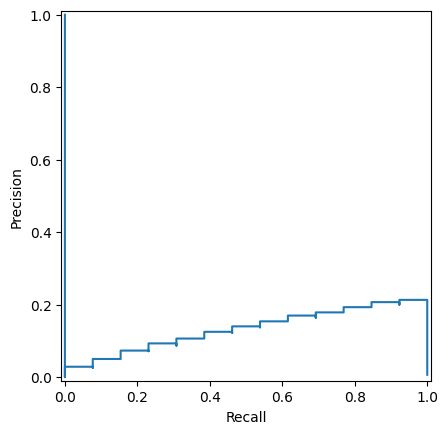

In [7]:
print(y_hat)
threshold = 0.5
#maxs = y_hat.argmax(dim=-1)
#print((y > 0.5).sum())
#print(torch.sigmoid(y_hat[0]))
print((y[0] > threshold).sum(dim=0))
print((torch.sigmoid(y_hat[0]) > threshold).sum(dim=0))

y_bin = (y[0] > threshold).int().numpy()
y_hat_bin = (torch.sigmoid(y_hat[0]) > threshold).int().numpy()

# print(y_bin)
# print(y_hat_bin)

precision, recall, thresholds = precision_recall_curve(y_bin[:, 0], torch.sigmoid(y_hat[0][:, 0]))
print(precision)
print(recall)
print(thresholds.shape)

print(y_bin.shape)
print(y_bin[:, 0].sum())
print(y_hat_bin[:, 0].sum())

report = classification_report(y_bin, y_hat_bin, labels=list(range(0, 68)), zero_division=1, output_dict=True)
print(report)

print(type(y_bin[:, 0]))
display = PrecisionRecallDisplay(
    recall=recall,
    precision=precision,
    #average_precision=average_precision["micro"],
   #prevalence_pos_label=Counter(y_bin[:, 0])/ y_bin[:, 0].size,
)

display.plot()